# Complete Hyperspectral Lime Data Analysis

This notebook demonstrates the complete workflow for hyperspectral data analysis, starting from raw data processing all the way to unsupervised clustering using deep learning approaches.

**Complete Pipeline:**
1. Raw data processing from tracq files
2. Mask creation and application
3. Dataset preparation
4. Model initialization
5. Model training
6. Model evaluation
7. Data visualization
8. Clustering and segmentation
9. Cluster analysis

## Setup

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path

notebook_dir = Path().absolute()
root_dir = notebook_dir.parent
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

from scripts.data_processing.hyperspectral_processor import HyperspectralProcessor
from scripts.models.dataset import MaskedHyperspectralDataset, load_hyperspectral_data, load_mask
from scripts.models.autoencoder import HyperspectralCAEWithMasking
from scripts.models.training import train_with_masking, evaluate_model_with_masking
from scripts.models.visualization import create_rgb_visualization, visualize_reconstruction_comparison, \
    overlay_clusters_on_rgb, visualize_4d_cluster_profiles_consistent, \
    overlay_clusters_with_consistent_colors
from scripts.models.clustering import run_pixel_wise_clustering, visualize_cluster_profiles, \
    run_4d_pixel_wise_clustering_setup_color, create_vibrant_colors

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

result_dir = os.path.join(root_dir, 'results', 'lime_analysis')
model_dir = os.path.join(result_dir, 'model')
eval_dir = os.path.join(result_dir, 'evaluation')
vis_dir = os.path.join(result_dir, 'visualizations')
cluster_dir = os.path.join(result_dir, 'clustering')

for d in [result_dir, model_dir, eval_dir, vis_dir, cluster_dir]:
    os.makedirs(d, exist_ok=True)
    
print(f"Results will be saved to: {result_dir}")

Using device: cuda
Results will be saved to: C:\Users\meloy\PycharmProjects\Capstone\results\lime_analysis


## Part 1: Raw Data Processing

In this section, we'll process the raw hyperspectral data files (.tracq files) and convert them into a structured format that can be used for analysis. We'll use the `HyperspectralProcessor` class to handle this.

In [2]:
from scripts.utils.process_trq_files import process_and_save

trq_folder_path = root_dir / "data" / "raw" / "Lime" / "TLS Scans"
output_path = root_dir / "data" / "raw" / "Lime" / "TLS Scans" / "average_power.xlsx"

power_data = process_and_save(trq_folder_path, output_path)

power_data.head()

Results saved to C:\Users\meloy\PycharmProjects\Capstone\data\raw\Lime\TLS Scans\average_power.xlsx


,Excitation Wavelength (nm),Average Power (W)
0,300.0,0.000041
1,310.0,0.000062
2,320.0,0.000084
3,330.0,0.000104
4,340.0,0.000129


In [3]:
data_path = root_dir / "data" / "raw" / "Lime"
metadata_path = data_path / "metadata.xlsx"
laser_power_excel = data_path / "TLS Scans" / "average_power.xlsx"
output_dir = root_dir / "data" / "processed" / "Lime"

os.makedirs(output_dir, exist_ok=True)

output_pkl = output_dir / "lime_data.pkl"
output_files = None
if output_pkl.exists():
    print(f"Processed data already exists at {output_pkl}")
    print("Skipping raw data processing. Delete the file if you want to reprocess.")
else:
    print("Starting raw data processing...")

    processor = HyperspectralProcessor(
        data_path=str(data_path),
        metadata_path=str(metadata_path),
        laser_power_excel=str(laser_power_excel),
        cutoff_offset=40,
        verbose=True
    )

    output_files = processor.process_full_pipeline(
        output_dir=str(output_dir),
        exposure_reference="max",
        power_reference="min",
        create_parquet=False,
        preserve_full_data=True
    )

    processor.print_summary()

    print(f"\nRaw data processing complete. Output files:")
    for file in output_files:
        print(f"  - {file}")

Processed data already exists at C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lime\lime_data.pkl
Skipping raw data processing. Delete the file if you want to reprocess.


## Part 2: Creating a Mask

After processing the raw data, we need to create a mask that identifies the regions of interest and/or removes invalid pixels. This can be done using the masking tool provided in the utils package.

**Note:** You may need to adjust this step based on your specific masking tool implementation.

In [4]:
from scripts.utils.masking_utils import create_masked_pickle


mask_path = output_dir / "lime_mask.npy"
try:
    data_path = output_files['power_normalized']
except TypeError:
    data_path = output_pkl
output_path_masked = output_dir / "lime_data.pkl"

if mask_path.exists():
    masked_file = create_masked_pickle(data_path, mask_path, output_path=output_path_masked)
else:
    print("""\nTo create a mask manually, you can use one of these approaches:
    1. Use the masking_tool.py tool in scripts/utils/ to visualize data and create a mask
    2. Create a simple binary mask in numpy and save it to the processed data directory
    3. Continue without a mask (all pixels will be considered valid)\n""")

Loading data from lime_data.pkl...
Loading mask from lime_mask.npy...
Finding and masking data cubes...
Found data cube at data.300.0.cube: shape=(256, 348, 22)
Found data cube at data.300.0.raw.data: shape=(256, 348, 31)
Found data cube at data.310.0.cube: shape=(256, 348, 22)
Found data cube at data.310.0.raw.data: shape=(256, 348, 31)
Found data cube at data.320.0.cube: shape=(256, 348, 22)
Found data cube at data.320.0.raw.data: shape=(256, 348, 31)
Found data cube at data.330.0.cube: shape=(256, 348, 22)
Found data cube at data.330.0.raw.data: shape=(256, 348, 31)
Found data cube at data.340.0.cube: shape=(256, 348, 22)
Found data cube at data.340.0.raw.data: shape=(256, 348, 31)
Found data cube at data.350.0.cube: shape=(256, 348, 24)
Found data cube at data.350.0.raw.data: shape=(256, 348, 31)
Found data cube at data.360.0.cube: shape=(256, 348, 26)
Found data cube at data.360.0.raw.data: shape=(256, 348, 31)
Found data cube at data.370.0.cube: shape=(256, 348, 28)
Found data cu

## 3. Load Processed Data

Now that we have processed data and a mask, we'll load them for analysis.

In [11]:
data_path = output_path_masked

if not data_path.exists():
    raise FileNotFoundError(f"Processed data file not found at {data_path}")

print("Loading kiwi hyperspectral data...")
data_dict = load_hyperspectral_data(data_path)

mask = None
if mask_path.exists():
    print("Loading mask...")
    mask = load_mask(mask_path)
else:
    print("No mask found, will process entire image")

Loading kiwi hyperspectral data...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lime\lime_data.pkl...
Data Summary:
Number of excitation wavelengths: 21
Excitation wavelengths: [300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0]
Data shape for first excitation (300.0 nm): (256, 348, 22)
Loading mask...
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lime\lime_mask.npy...
Mask loaded: 61833/89088 valid pixels (69.41%)


## 4. Create Dataset

Next, we'll create the `MaskedHyperspectralDataset` for the kiwi data. This handles preprocessing, normalization, and masking.

In [12]:
normalize = True
downscale_factor = 1  # Set > 1 to reduce spatial dimensions

print("Creating dataset...")
dataset = MaskedHyperspectralDataset(
    data_dict=data_dict,
    mask=mask,
    normalize=normalize,
    downscale_factor=downscale_factor
)

height, width = dataset.get_spatial_dimensions()
print(f"Data dimensions: {height}x{width}")

excitation_wavelengths = dataset.excitation_wavelengths
print(f"Available excitation wavelengths: {excitation_wavelengths}")

Creating dataset...
Preparing data for 21 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 300.0 nm: 22 bands
  - Excitation 310.0 nm: 22 bands
  - Excitation 320.0 nm: 22 bands
  - Excitation 330.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 350.0 nm: 24 bands
  - Excitation 360.0 nm: 26 bands
  - Excitation 370.0 nm: 28 bands
  - Excitation 380.0 nm: 30 bands
  - Excitation 390.0 nm: 30 bands
  - Excitation 400.0 nm: 29 bands
  - Excitation 410.0 nm: 28 bands
  - Excitation 420.0 nm: 27 bands
  - Excitation 430.0 nm: 26 bands
  - Excitation 440.0 nm: 25 bands
  - Excitation 450.0 nm: 24 bands
  - Excitation 460.0 nm: 23 bands
  - Excitation 470.0 nm: 22 bands
  - Excitation 480.0 nm: 21 bands
  - Excitation 490.0 nm: 20 bands
  - Excitation 500.0 nm: 19 bands
Mask processed. Valid pixels: 61833.0/89088 (69.41%)
Global data range (valid values only): [0.0000, 14665.0456]
Data normalized to range [0, 1] using global normal

## 5. Create Model

Now, we'll create the `HyperspectralCAEWithMasking` model that will learn to encode and decode the hyperspectral data.

In [13]:
all_data = dataset.get_all_data()

k1 = 20
k3 = 20
filter_size = 5
sparsity_target = 0.1
sparsity_weight = 1.0
dropout_rate = 0.5

print("Creating model...")
model = HyperspectralCAEWithMasking(
    excitations_data={ex: data.numpy() for ex, data in all_data.items()},
    k1=k1,
    k3=k3,
    filter_size=filter_size,
    sparsity_target=sparsity_target,
    sparsity_weight=sparsity_weight,
    dropout_rate=dropout_rate
)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

Creating model...
Model created with 329472 parameters


## 6. Train Model

Now we'll train the model using the `train_with_masking` function, which efficiently processes the data in chunks and handles masked regions.

In [14]:
num_epochs = 50
learning_rate = 0.001
chunk_size = 256
chunk_overlap = 64
early_stopping_patience = 5

best_model_path = os.path.join(model_dir, "best_hyperspectral_model.pth")

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print('Loaded Defined Model')
else:
    model, losses = train_with_masking(
        model=model,
        dataset=dataset,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        batch_size=1,
        device=device,
        early_stopping_patience=early_stopping_patience,
        mask=dataset.processed_mask,
        output_dir=model_dir
    )

    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(model_dir, "loss_curve.png"), dpi=300, bbox_inches='tight')
    plt.show()

Loaded Defined Model


## 7. Evaluate Model

Now we'll evaluate the trained model and calculate metrics on the reconstruction quality.

In [15]:
print("Evaluating model...")
evaluation_results = evaluate_model_with_masking(
    model=model,
    dataset=dataset,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    device=device,
    output_dir=eval_dir
)

reconstructions = evaluation_results['reconstructions']

if 'overall' in evaluation_results['metrics']:
    overall_metrics = evaluation_results['metrics']['overall']
    print(f"Overall RMSE: {np.sqrt(overall_metrics['mse']):.4f}")
    print(f"Overall MAE: {overall_metrics['mae']:.4f}")
    print(f"Overall PSNR: {overall_metrics['psnr']:.2f} dB")

Evaluating model...
Evaluating model on test data...
Excitation 300.0nm - MSE: 0.0068, MAE: 0.0819, PSNR: 21.66 dB (on 1360326.0 valid pixels)
Excitation 310.0nm - MSE: 0.0067, MAE: 0.0815, PSNR: 21.71 dB (on 1360326.0 valid pixels)
Excitation 320.0nm - MSE: 0.0061, MAE: 0.0778, PSNR: 22.11 dB (on 1360326.0 valid pixels)
Excitation 330.0nm - MSE: 0.0064, MAE: 0.0794, PSNR: 21.96 dB (on 1360326.0 valid pixels)
Excitation 340.0nm - MSE: 0.0065, MAE: 0.0799, PSNR: 21.90 dB (on 1360326.0 valid pixels)
Excitation 350.0nm - MSE: 0.0063, MAE: 0.0787, PSNR: 22.04 dB (on 1483992.0 valid pixels)
Excitation 360.0nm - MSE: 0.0068, MAE: 0.0817, PSNR: 21.70 dB (on 1607658.0 valid pixels)
Excitation 370.0nm - MSE: 0.0069, MAE: 0.0827, PSNR: 21.62 dB (on 1731324.0 valid pixels)
Excitation 380.0nm - MSE: 0.0069, MAE: 0.0827, PSNR: 21.61 dB (on 1854990.0 valid pixels)
Excitation 390.0nm - MSE: 0.0065, MAE: 0.0798, PSNR: 21.88 dB (on 1854990.0 valid pixels)
Excitation 400.0nm - MSE: 0.0065, MAE: 0.0789, 

## 8. Visualize Results

Let's create visualizations of the original and reconstructed data.

In [16]:
print("Creating RGB visualizations of original data...")
original_rgb = create_rgb_visualization(
    data_dict=all_data,
    emission_wavelengths=dataset.emission_wavelengths,
    mask=dataset.processed_mask,
    output_dir=vis_dir
)

print("Creating RGB visualizations of reconstructed data...")
recon_rgb = create_rgb_visualization(
    data_dict=reconstructions,
    emission_wavelengths=dataset.emission_wavelengths,
    mask=dataset.processed_mask,
    output_dir=os.path.join(vis_dir, 'reconstructed')
)

print("Creating detailed reconstruction comparisons...")
for ex in all_data:
    if ex in reconstructions:
        metrics = visualize_reconstruction_comparison(
            original_data=all_data[ex],
            reconstructed_data=reconstructions[ex],
            excitation=ex,
            emission_wavelengths=dataset.emission_wavelengths.get(ex, None),
            mask=dataset.processed_mask,
            output_dir=vis_dir
        )
        print(f"Excitation {ex}nm - RMSE: {metrics['rmse']:.4f}, PSNR: {metrics['psnr']:.2f} dB")

Creating RGB visualizations of original data...
Ex=300.0nm: Using R=650.0nm, G=550.0nm, B=450.0nm
Ex=310.0nm: Using R=670.0nm, G=550.0nm, B=450.0nm
Ex=320.0nm: Using R=690.0nm, G=550.0nm, B=450.0nm
Ex=330.0nm: Using R=610.0nm, G=550.0nm, B=450.0nm
Ex=340.0nm: Using R=630.0nm, G=550.0nm, B=450.0nm
Ex=350.0nm: Using R=650.0nm, G=550.0nm, B=450.0nm
Ex=360.0nm: Using R=650.0nm, G=550.0nm, B=450.0nm
Ex=370.0nm: Using R=650.0nm, G=550.0nm, B=450.0nm
Ex=380.0nm: Using R=650.0nm, G=550.0nm, B=450.0nm
Ex=390.0nm: Using R=650.0nm, G=550.0nm, B=450.0nm
Ex=400.0nm: Using R=650.0nm, G=550.0nm, B=450.0nm
Ex=410.0nm: Using R=650.0nm, G=550.0nm, B=450.0nm
Ex=420.0nm: Using R=650.0nm, G=550.0nm, B=460.0nm
Ex=430.0nm: Using R=650.0nm, G=550.0nm, B=470.0nm
Ex=440.0nm: Using R=650.0nm, G=550.0nm, B=480.0nm
Ex=450.0nm: Using R=650.0nm, G=550.0nm, B=490.0nm
Ex=460.0nm: Using R=650.0nm, G=550.0nm, B=500.0nm
Ex=470.0nm: Using R=650.0nm, G=550.0nm, B=510.0nm
Ex=480.0nm: Using R=650.0nm, G=550.0nm, B=520.0nm
Ex

## 9. Run Clustering

Now we'll perform pixel-wise clustering to segment the image into regions with similar spectral profiles.

Running 4D pixel-wise clustering with 7 clusters...
Starting 4D pixel-wise clustering...
Extracting encoded features...
Extracting features for excitation 300.0...
Extracted 20 features for excitation 300.0
Extracting features for excitation 310.0...
Extracted 20 features for excitation 310.0
Extracting features for excitation 320.0...
Extracted 20 features for excitation 320.0
Extracting features for excitation 330.0...
Extracted 20 features for excitation 330.0
Extracting features for excitation 340.0...
Extracted 20 features for excitation 340.0
Extracting features for excitation 350.0...
Extracted 20 features for excitation 350.0
Extracting features for excitation 360.0...
Extracted 20 features for excitation 360.0
Extracting features for excitation 370.0...
Extracted 20 features for excitation 370.0
Extracting features for excitation 380.0...
Extracted 20 features for excitation 380.0
Extracting features for excitation 390.0...
Extracted 20 features for excitation 390.0
Extracting

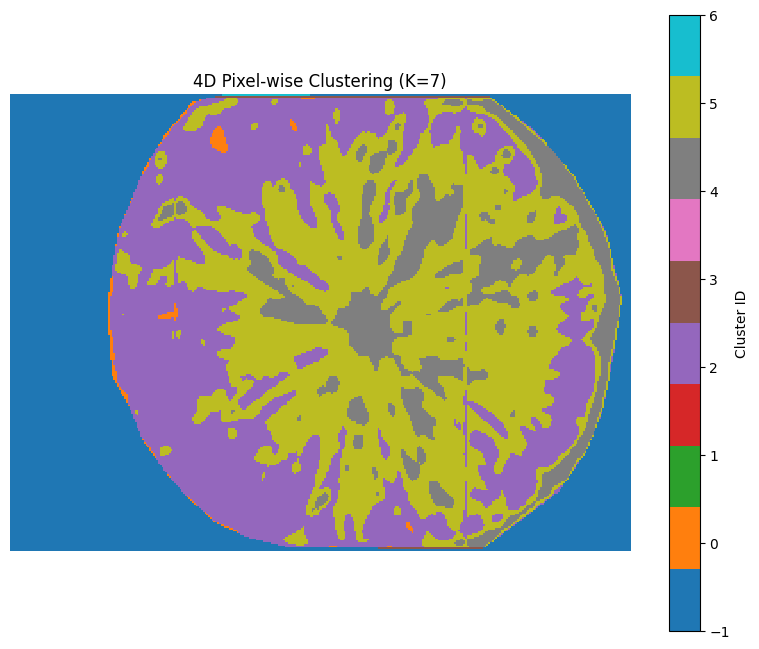

In [17]:
from scripts.models.clustering import run_pixel_wise_clustering, run_4d_pixel_wise_clustering, visualize_cluster_profiles

n_clusters = 7

print(f"Running 4D pixel-wise clustering with {n_clusters} clusters...")
cluster_results = run_4d_pixel_wise_clustering(
    model=model,
    dataset=dataset,
    n_clusters=n_clusters,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    device=device,
    output_dir=cluster_dir,
    calculate_metrics=True,
    use_pca=False
)

print(f"Clustering performed using all {len(cluster_results['excitations_used'])} excitations")

cluster_labels = cluster_results['cluster_labels']

unique_clusters = sorted([c for c in np.unique(cluster_labels) if c >= 0])
cluster_counts = {c: np.sum(cluster_labels == c) for c in unique_clusters}

print("Cluster distribution:")
for cluster_id, count in cluster_counts.items():
    percentage = (count / np.sum(list(cluster_counts.values()))) * 100
    print(f"  Cluster {cluster_id}: {count} pixels ({percentage:.2f}%)")

plt.figure(figsize=(10, 8))
plt.imshow(cluster_labels, cmap='tab10', interpolation='nearest')
plt.colorbar(label='Cluster ID')
plt.title(f'4D Pixel-wise Clustering (K={n_clusters})')
plt.axis('off')
plt.savefig(os.path.join(cluster_dir, f"4d_cluster_map_k{n_clusters}.png"), dpi=300, bbox_inches='tight')
plt.show()

## 10. Analyze Cluster Profiles

Let's examine the spectral profiles of each cluster to understand what makes them distinct.

Analyzing 4D cluster spectral profiles...
Analyzing profiles for clusters using 21 excitation wavelengths
Analyzing profiles for 6 clusters
Creating cluster overlay visualization...
Using excitation 300.0nm for RGB visualization
Overlay image saved to C:\Users\meloy\PycharmProjects\Capstone\results\lime_analysis\clustering\4d_cluster_overlay.png


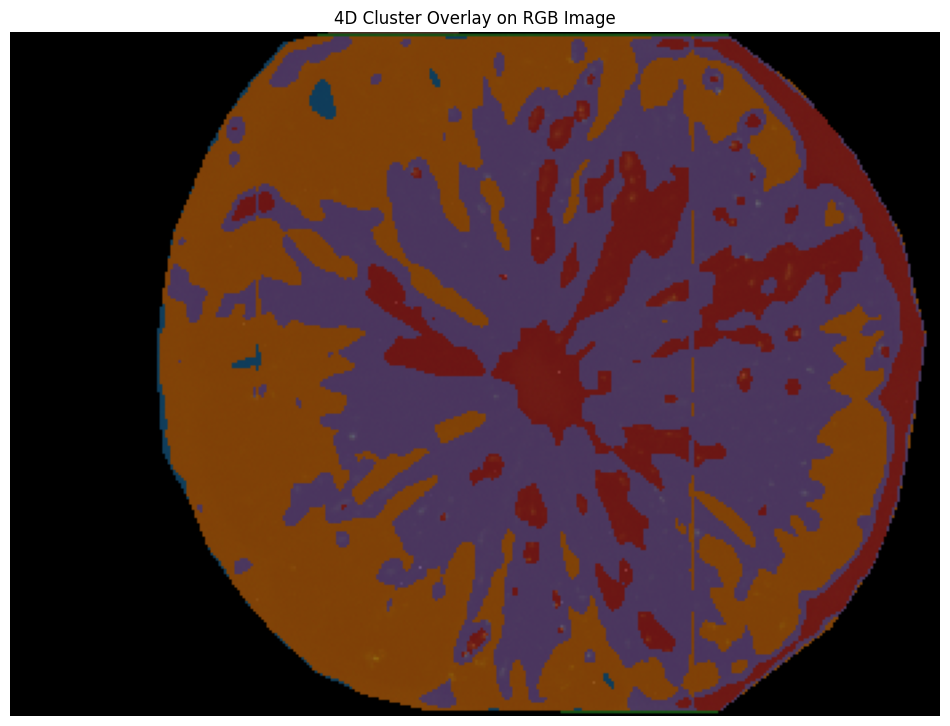

In [18]:
from scripts.models.clustering import visualize_4d_cluster_profiles

print("Analyzing 4D cluster spectral profiles...")
cluster_stats = visualize_4d_cluster_profiles(
    cluster_results=cluster_results,
    dataset=dataset,
    original_data=all_data,
    output_dir=cluster_dir
)

print("Creating cluster overlay visualization...")
visualization_excitation = cluster_results['excitations_used'][0]
print(f"Using excitation {visualization_excitation}nm for RGB visualization")

overlay = overlay_clusters_on_rgb(
    cluster_labels=cluster_results['cluster_labels'],
    rgb_image=original_rgb[visualization_excitation],
    mask=dataset.processed_mask,
    output_path=os.path.join(cluster_dir, "4d_cluster_overlay.png")
)

plt.figure(figsize=(12, 10))
plt.imshow(overlay)
plt.title('4D Cluster Overlay on RGB Image')
plt.axis('off')
plt.show()

## 11. Comparative Analysis

Finally, let's examine how the number of clusters affects the segmentation results.

Running 4D clustering with k=4...
Starting 4D pixel-wise clustering...
Extracting encoded features...
Extracting features for excitation 300.0...
Extracted 20 features for excitation 300.0
Extracting features for excitation 310.0...
Extracted 20 features for excitation 310.0
Extracting features for excitation 320.0...
Extracted 20 features for excitation 320.0
Extracting features for excitation 330.0...
Extracted 20 features for excitation 330.0
Extracting features for excitation 340.0...
Extracted 20 features for excitation 340.0
Extracting features for excitation 350.0...
Extracted 20 features for excitation 350.0
Extracting features for excitation 360.0...
Extracted 20 features for excitation 360.0
Extracting features for excitation 370.0...
Extracted 20 features for excitation 370.0
Extracting features for excitation 380.0...
Extracted 20 features for excitation 380.0
Extracting features for excitation 390.0...
Extracted 20 features for excitation 390.0
Extracting features for exci

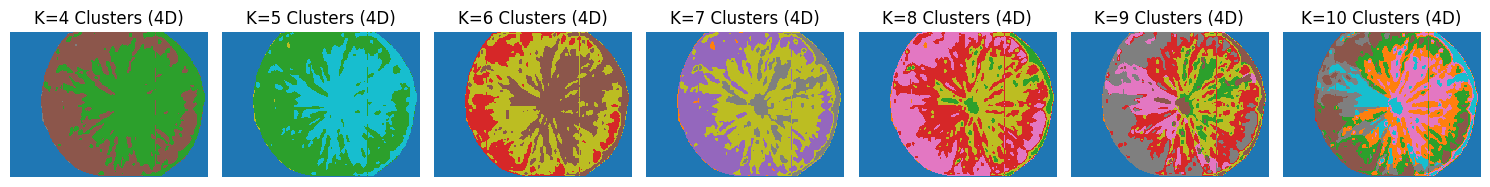


4D Clustering Quality Metrics by K:
K=4:
  Silhouette Score: 0.3702
  Davies-Bouldin Index: 0.6399
  Calinski-Harabasz Index: 60297.6790
  Spatial Coherence: 0.9448
K=5:
  Silhouette Score: 0.3594
  Davies-Bouldin Index: 0.4990
  Calinski-Harabasz Index: 83978.2324
  Spatial Coherence: 0.9424
K=6:
  Silhouette Score: 0.3154
  Davies-Bouldin Index: 0.5844
  Calinski-Harabasz Index: 88793.2785
  Spatial Coherence: 0.9132
K=7:
  Silhouette Score: 0.3133
  Davies-Bouldin Index: 0.6500
  Calinski-Harabasz Index: 96473.2471
  Spatial Coherence: 0.9110
K=8:
  Silhouette Score: 0.3050
  Davies-Bouldin Index: 0.7123
  Calinski-Harabasz Index: 97281.0330
  Spatial Coherence: 0.8894
K=9:
  Silhouette Score: 0.2896
  Davies-Bouldin Index: 0.7984
  Calinski-Harabasz Index: 97944.8522
  Spatial Coherence: 0.8682
K=10:
  Silhouette Score: 0.3015
  Davies-Bouldin Index: 0.7425
  Calinski-Harabasz Index: 106929.2201
  Spatial Coherence: 0.8528


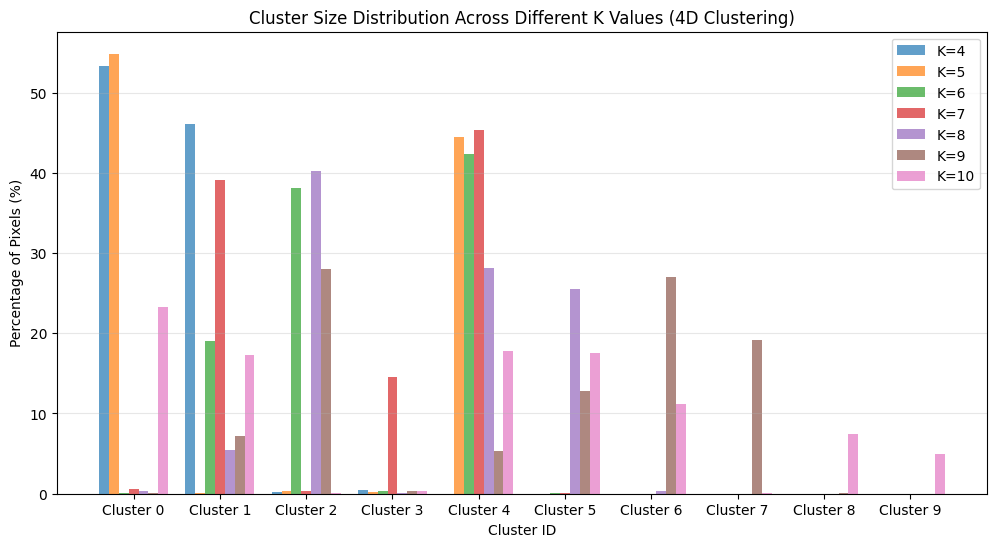

In [19]:
cluster_numbers = [4,5,6,7,8,9,10]
cluster_results_by_k = {}

plt.figure(figsize=(15, 5))

for i, k in enumerate(cluster_numbers):
    print(f"Running 4D clustering with k={k}...")

    results_k = run_4d_pixel_wise_clustering(
        model=model,
        dataset=dataset,
        n_clusters=k,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        device=device,
        output_dir=os.path.join(cluster_dir, f"4d_k_{k}"),
        calculate_metrics=True,
        use_pca=False
    )

    cluster_stats = visualize_4d_cluster_profiles(
    cluster_results=results_k,
    dataset=dataset,
    original_data=all_data,
    output_dir=os.path.join(cluster_dir, f"4d_k_{k}")
    )
    cluster_results_by_k[k] = results_k

    plt.subplot(1, len(cluster_numbers), i+1)
    plt.imshow(results_k['cluster_labels'], cmap='tab10', interpolation='nearest')
    plt.title(f'K={k} Clusters (4D)')
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(cluster_dir, "4d_cluster_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

print("\n4D Clustering Quality Metrics by K:")
for k, results in cluster_results_by_k.items():
    if 'metrics' in results:
        metrics = results['metrics']
        print(f"K={k}:")
        if 'silhouette_score' in metrics:
            print(f"  Silhouette Score: {metrics['silhouette_score']:.4f}")
        if 'davies_bouldin_score' in metrics:
            print(f"  Davies-Bouldin Index: {metrics['davies_bouldin_score']:.4f}")
        if 'calinski_harabasz_score' in metrics:
            print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz_score']:.4f}")
        if 'spatial_coherence' in metrics:
            print(f"  Spatial Coherence: {metrics['spatial_coherence']:.4f}")

plt.figure(figsize=(12, 6))

for i, k in enumerate(cluster_numbers):
    results = cluster_results_by_k[k]
    labels = results['cluster_labels']
    unique_clusters = sorted([c for c in np.unique(labels) if c >= 0])
    cluster_sizes = [np.sum(labels == c) for c in unique_clusters]

    total_pixels = sum(cluster_sizes)
    cluster_percentages = [100 * size / total_pixels for size in cluster_sizes]

    bar_width = 0.8 / len(cluster_numbers)
    positions = np.arange(len(unique_clusters)) + (i - len(cluster_numbers)/2 + 0.5) * bar_width

    plt.bar(
        positions,
        cluster_percentages,
        width=bar_width,
        label=f'K={k}',
        alpha=0.7
    )

plt.xlabel('Cluster ID')
plt.ylabel('Percentage of Pixels (%)')
plt.title('Cluster Size Distribution Across Different K Values (4D Clustering)')
plt.xticks(np.arange(max([len(np.unique(cluster_results_by_k[k]['cluster_labels'][cluster_results_by_k[k]['cluster_labels'] >= 0])) for k in cluster_numbers])),
          [f'Cluster {i}' for i in range(max([len(np.unique(cluster_results_by_k[k]['cluster_labels'][cluster_results_by_k[k]['cluster_labels'] >= 0])) for k in cluster_numbers]))])
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.savefig(os.path.join(cluster_dir, "4d_cluster_size_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

Running 4D clustering with k=9...
Starting 4D pixel-wise clustering...
Extracting encoded features...
Extracting features for excitation 300.0...
Extracted 20 features for excitation 300.0
Extracting features for excitation 310.0...
Extracted 20 features for excitation 310.0
Extracting features for excitation 320.0...
Extracted 20 features for excitation 320.0
Extracting features for excitation 330.0...
Extracted 20 features for excitation 330.0
Extracting features for excitation 340.0...
Extracted 20 features for excitation 340.0
Extracting features for excitation 350.0...
Extracted 20 features for excitation 350.0
Extracting features for excitation 360.0...
Extracted 20 features for excitation 360.0
Extracting features for excitation 370.0...
Extracted 20 features for excitation 370.0
Extracting features for excitation 380.0...
Extracted 20 features for excitation 380.0
Extracting features for excitation 390.0...
Extracted 20 features for excitation 390.0
Extracting features for exci

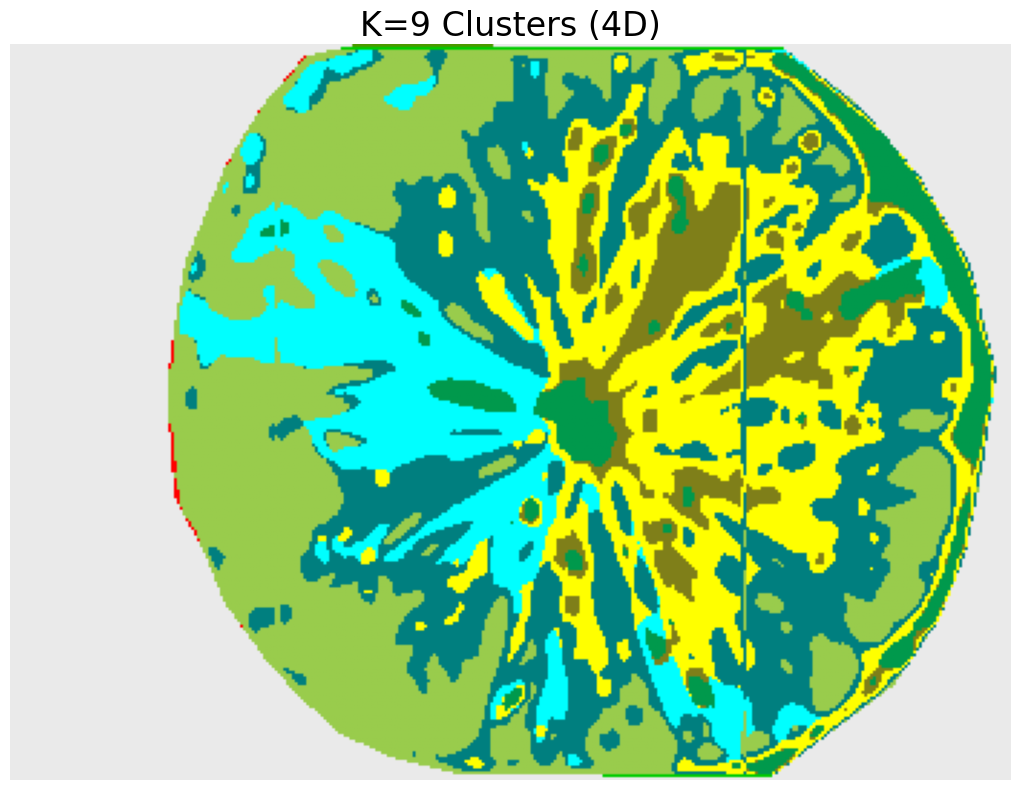

In [26]:
vibrant_colors = create_vibrant_colors(max(cluster_numbers) + 1)
cluster_numbers = [9]

color_mappings = {}
for k in cluster_numbers:
    color_mapping = {-1: vibrant_colors[0]}
    for i in range(k):
        color_mapping[i] = vibrant_colors[i + 1]
    color_mappings[k] = color_mapping

cluster_results_by_k = {}

plt.figure(figsize=(24, 8))

for i, k in enumerate(cluster_numbers):
    print(f"Running 4D clustering with k={k}...")

    results_k = run_4d_pixel_wise_clustering_setup_color(
        model=model,
        dataset=dataset,
        n_clusters=k,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        device=device,
        output_dir=os.path.join(cluster_dir, f"4d_k_{k}"),
        calculate_metrics=False,
        use_pca=False,
        custom_colors=color_mappings[k]
    )

    cluster_stats = visualize_4d_cluster_profiles_consistent(
        cluster_results=results_k,
        dataset=dataset,
        original_data=all_data,
        output_dir=os.path.join(cluster_dir, f"4d_k_{k}"),
        color_mapping=color_mappings[k]
    )

    visualization_excitation = results_k['excitations_used'][0]
    overlay = overlay_clusters_with_consistent_colors(
        cluster_labels=results_k['cluster_labels'],
        rgb_image=original_rgb[visualization_excitation],
        mask=dataset.processed_mask,
        output_path=os.path.join(cluster_dir, f"4d_k_{k}", "4d_cluster_overlay.png"),
        color_mapping=color_mappings[k]
    )

    cluster_results_by_k[k] = results_k

    plt.subplot(1, len(cluster_numbers), i+1)

    cluster_image = np.zeros((*results_k['cluster_labels'].shape, 3))
    for cluster_id in np.unique(results_k['cluster_labels']):
        mask = results_k['cluster_labels'] == cluster_id
        if cluster_id >= 0:
            cluster_image[mask] = color_mappings[k][cluster_id][:3]
        else:
            cluster_image[mask] = color_mappings[k][-1][:3]

    plt.imshow(cluster_image)
    plt.title(f'K={k} Clusters (4D)', fontsize=24)
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(cluster_dir, "4d_cluster_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()